<a href="https://colab.research.google.com/github/FedericoRaschiatore0123/Deep_Learning_project/blob/main/Emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Emotion Recognition
In this notebook we implemented our implementation of the emotion recognition for classify emotion.
We used the FER2013 Dataset and implemented the paper "PAtt-Lite: Lightweight Patch and Attention MobileNet for Challenging Facial Expression Recognition".

The structure of the model is the following:

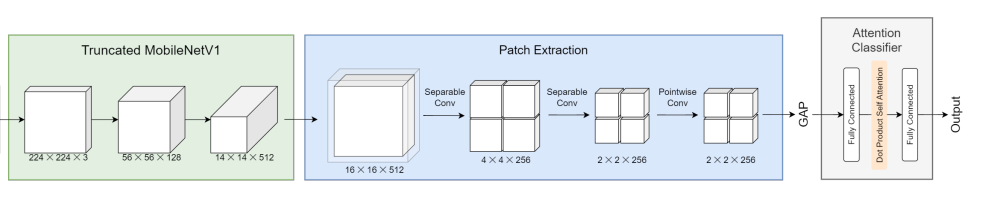

We implemented the following steps:


1.   We imported the dataset from our repository on github
2.   We used the truncated pretrained MobileNetV2 to extract features from the image
3.   We implemented a patch_extraction composed by 2 Separable convolutional layers and a Pointwise convolutional layer
4.   We used a ViT for the image classification





#References:


*   PAtt-Lite:    https://arxiv.org/pdf/2306.09626v1.pdf
*   FER2013:     https://paperswithcode.com/dataset/fer2013
*   MobileNetV2:    https://arxiv.org/pdf/1801.04381.pdf
*   ViT:     https://arxiv.org/pdf/2010.11929.pdf





##Import

In this section we imported all the libraries.
We decided to use the pytorch lightning framework to simplify the training and the test

In [ ]:
!pip install pytorch_lightning --quiet
!pip install einops

In [ ]:
!rm -r Vision_and_Perception
!git clone https://github.com/FedericoRaschiatore0123/Vision_and_Perception
%cd Vision_and_Perception

In [ ]:
!unzip Train_1.zip -d train
!unzip Train_2.zip -d train
!unzip Train_3.zip -d train
!unzip test.zip -d test

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import random
import pytorch_lightning as pl
from torchvision import datasets, transforms

BATCH_SIZE=128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images.shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

In [ ]:
# Specifica il percorso del tuo dataset
train_path = "../Vision_and_Perception/train"
test_path = "../Vision_and_Perception/test"
# Data augmentation
transformation = tt.Compose([ tt.Resize((224, 224)),
                              tt.ToTensor(),
                         ])

# Carica il dataset
train_dataset = datasets.ImageFolder(root=train_path, transform=transformation)
test_dataset = datasets.ImageFolder(root=test_path, transform=transformation)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([128, 3, 224, 224])
225


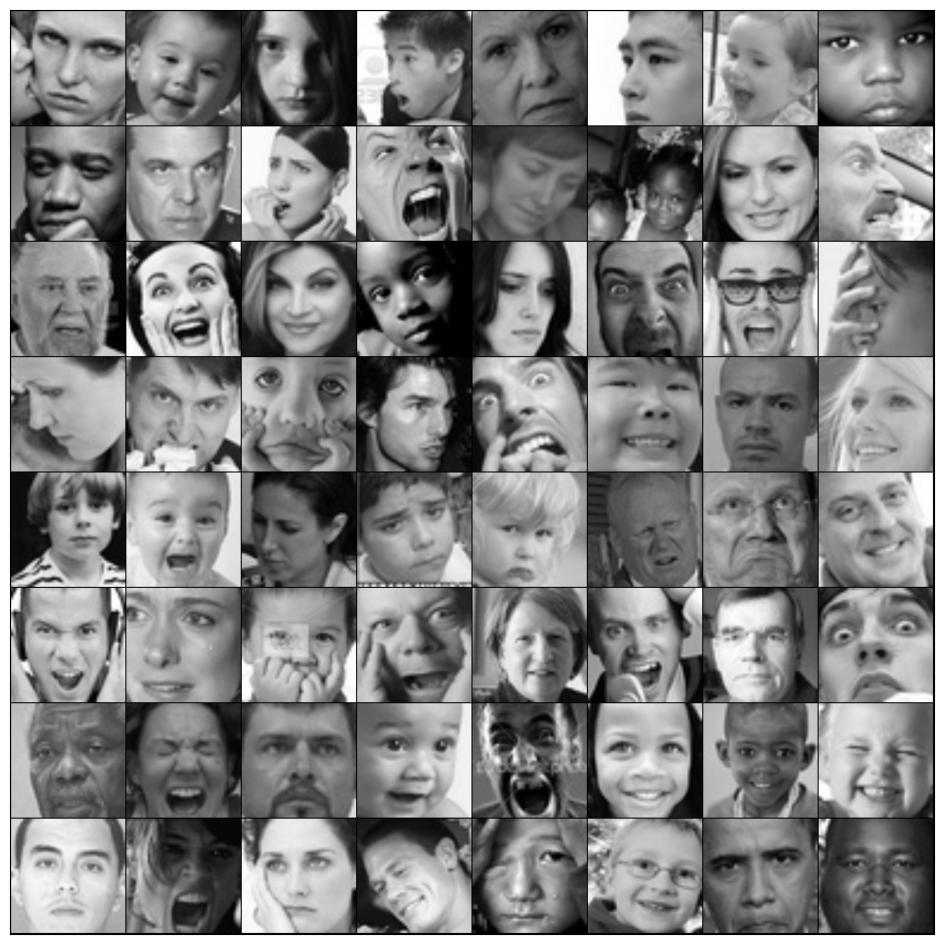

In [ ]:
show_batch(train_dataloader)
print(len(train_dataloader))

## Feature extraction

In this section we implemented the feature extraction using the MobileNetV2 truncated to remove the fully connected layers.
We also used the PatchExtractionBlock to pass from a dimensionality of 14x14x96 to 2x2x42.


To do this we used 2 Separable Convolution Layers and a Pointwise Convolution Layer

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image

def feature_extraction(dataset):
    # Carica il modello MobileNetV1 pre-addestrato senza i layer fully connected
    model = models.mobilenet_v2(pretrained=True).features
    model = nn.Sequential(*list(model.children())[:-5]).to(device)

    model.eval()

    features = []
    labels = []

    image, label = dataset
    image = image.to(device)
    # Estrae le feature
    with torch.no_grad():
        feature = model(image)

    return feature

#extracted_features = feature_extraction(train_dataloader)
#print(extracted_features)

In [ ]:
from re import X
import torch as t
import torch.nn as nn
import numpy as np

"""def patch_image(image, patch_size):
    height, width = image[0].shape[1:]
    patched_images = []

    for im in image:
      patches = []
      for y in range(0, height, patch_size):
          for x in range(0, width, patch_size):
              patch = im[:,y:y+patch_size, x:x+patch_size]
              patches.append(patch)

      patches = torch.stack(patches)
      patched_images.append(patches)

    patched_images = torch.stack(patched_images)
    return patched_images"""

class PatchExtractionBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(PatchExtractionBlock, self).__init__()

        # Primo strato convolutivo separabile in profondità
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, input_channels, kernel_size=13, groups=input_channels, padding=1),
            nn.Conv2d(input_channels, output_channels, kernel_size=1),
            nn.ReLU(inplace=True)
        )

        # Secondo strato convolutivo separabile in profondità
        self.conv2 = nn.Sequential(
            nn.Conv2d(output_channels, output_channels, kernel_size=3, groups=output_channels),
            nn.Conv2d(output_channels, output_channels, kernel_size=1),
            nn.ReLU(inplace=True)
        )

        # Ultimo strato convolutivo pointwise
        self.conv3 = nn.Conv2d(output_channels, output_channels, kernel_size=1)

    def forward(self, x):
        # Applica i tre strati sequenzialmente
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        return out


# ViT

In [ ]:
#Utilities

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn=fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)


In [ ]:
from einops.layers.torch import Rearrange
from einops import repeat

class PatchEmbedding(pl.LightningModule):
    def __init__(self, channels, patch_size=2, emb_size=128):
        super().__init__()
        self.channels = channels
        self.patch_size = patch_size
        self.emb_size = emb_size

        self.flatten = nn.Sequential(
            Rearrange('b c h w -> b (c h w)'),
            nn.Linear(channels * patch_size * patch_size, emb_size)
        )

    def forward(self, x):
        x = self.flatten(x)
        return x


In [ ]:
class Attention(pl.LightningModule):
  def __init__(self, emb_dim, num_heads):
    super(Attention, self).__init__()
    self.emb_dim=emb_dim
    self.num_heads = num_heads

    self.attention = nn.MultiheadAttention(self.emb_dim, self.num_heads, dropout=0.1)

    self.q = nn.Linear(emb_dim, emb_dim)
    self.k = nn.Linear(emb_dim, emb_dim)
    self.v = nn.Linear(emb_dim, emb_dim)

  def forward(self, x):
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)
    attention, attention_weights = self.attention(q, k, v)
    return attention

In [ ]:
class ViT(pl.LightningModule):
  def __init__(self, emb_dim, hidden_dim, out_dim, channels, input_channels=96, output_channels=48, n_layers = 4, patch_size=8,  img_size=48, dropout=0.1, num_heads = 4):
    super(ViT, self).__init__()
    self.emb_dim = emb_dim
    self.num_heads = num_heads
    self.hidden_dim = hidden_dim
    self.dropout = dropout
    self.channels = channels
    self.img_width = img_size
    self.img_height = img_size
    self.patch_size = patch_size
    self.n_layers = n_layers

    self.patch_embedding = PatchEmbedding(channels)

    self.patch_extraction = PatchExtractionBlock(input_channels, output_channels)

    self.positional_emb = nn.Parameter(
        torch.randn(1, 2, emb_dim)
    )
    self.cls_token = nn.Parameter(
        torch.randn(1, 1, emb_dim)
    )


    self.layers = nn.ModuleList([])
    block = nn.Sequential(

        Residual(PreNorm(2, Attention(emb_dim, num_heads))),

        Residual(PreNorm(2, nn.Sequential(nn.Linear(emb_dim, hidden_dim),
                                                nn.ReLU(),
                                                nn.Dropout(dropout),
                                                nn.Linear(hidden_dim, emb_dim),
                                                nn.Dropout(dropout)
                                            )))
    )
    self.layers=block

    self.classification_head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))

  def forward(self, images):

      images = feature_extraction(images)
      images = self.patch_extraction(images)
      x = self.patch_embedding(images)
      b, n = x.shape

      cls_token = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
      x = torch.unsqueeze(x, 1)
      x = torch.cat((cls_token, x), dim=1)
      x += self.positional_emb[:, : ,:(n+1)]

      x = self.layers(x)
      return self.classification_head(x[:, 0, :])

  def training_step(self, batch, batch_idx):
        output = self(batch)
        Loss = nn.CrossEntropyLoss()
        loss = Loss(
            output, batch[1])
        losses.append(loss.cpu().detach().numpy())
        print("train_loss", loss)
        return loss

  def validation_step(self, batch, batch_idx):

      return True

  def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
      return optimizer

  def test_step(self, batch, batch_idx):
      output = self(batch)

      acc.append(accuracy(output, batch[1]))
      return acc

acc=[]
losses = []
model = ViT(128, 256, 7, 48)

trainer = pl.Trainer(max_epochs=15)
trainer.fit(model, train_dataloader)

In [ ]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, train_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                 | Params
-------------------------------------------------------------
0 | patch_embedding     | PatchEmbedding       | 24.7 K
1 | patch_extraction    | PatchExtractionBlock | 26.2 K
2 | layers              | Sequential           | 181 K 
3 | classification_head | Sequential           | 1.2 K 
  | other params        | n/a                  | 384   
-------------------------------------------------------------
233 K     Trainable params
0         Non-trainable params
233 K     Total params
0.93

Training: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(1.0929, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(1.0286, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(1.0414, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(0.9364, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(1.0599, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(0.8739, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(0.9599, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(0.9635, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(1.0361, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(1.0649, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(1.0354, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(0.9262, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(1.1354, device='cuda:0', grad_fn=<NllLossBackward0>)
train_loss tensor(1.0129, device='cuda:0', grad_fn=<NllLossBackward0>)
train_

In [ ]:
model_path = "./model.pth"
torch.save(model.state_dict(), model_path)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

0.12548828125


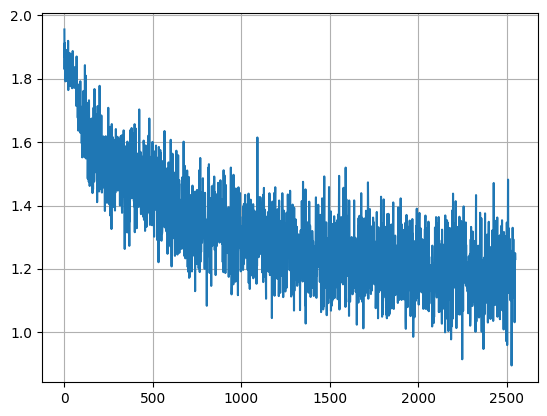

In [ ]:
def accuracy(predicted_output, correct_output):

    real_output=[]
    num_correct_answers=0
    for i in range(len(predicted_output)):

        index = torch.argmax(predicted_output[i])

        if index == correct_output[i]:
            num_correct_answers += 1

    return num_correct_answers / len(predicted_output)


trainer.test(model,test_dataloader)
print(sum(acc)/len(acc))
plt.plot(losses)
plt.grid()
plt.show()